# Analysis of HIV Treatment Effects - Full Compliance Dataset

This notebook explores the HIV treatment dataset with full compliance (where all treated patients receive the treatment and no control patients receive it). We'll:

1. Load and explore the dataset
2. Visualize key relationships and distributions
3. Apply simple statistical test to estimate the treatment effect with and without covariate
4. Estimate the causal structure and use this to estimate the effect
5. Compare the different estimates to the true effect

In [50]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dowhy import CausalModel
import warnings

In [51]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [10, 6]
warnings.filterwarnings('ignore')

## 1. Load and Explore the Dataset

In [52]:
# Load the dataset
df = pd.read_pickle(os.path.join('data', 'hiv_full_compliance.pkl'))

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (20000, 11)


,uninfected_t1,infected_t1,uninfected_t2,infected_t2,free_virus,immune_response,enrolled,treatment,outcome,true_effect,experiment_number
0,168013.251186,10489.816212,5.803810,45.168350,56416.289700,27.226979,1,1,46.859652,1.206532,0
1,168354.340012,10364.747125,5.874707,45.167844,55740.078929,27.125079,0,0,45.656999,1.185633,0
2,166845.707563,11993.112619,5.081023,45.240082,64492.721511,26.118460,0,0,45.606440,1.356003,0
3,168625.302731,10280.627778,5.923619,45.168924,55284.586066,26.585281,0,0,45.659628,1.170306,0
4,167492.055491,10686.562443,5.695729,45.169672,57480.010583,27.183053,1,1,46.886269,1.239227,0


In [53]:
# Summary statistics
df.describe()

,uninfected_t1,infected_t1,uninfected_t2,infected_t2,free_virus,immune_response,enrolled,treatment,outcome,true_effect,experiment_number
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,168032.969380,10636.924951,5.731304,45.179431,57204.135197,26.792624,0.504400,0.504400,46.261963,1.216762,49.500000
std,793.885715,366.468259,0.187008,0.019837,1972.887601,0.615833,0.499993,0.499993,0.609029,0.049160,28.866792
min,165907.538362,10148.454267,4.759612,45.167177,54508.632049,24.428176,0.000000,0.000000,45.588367,1.036482,0.000000
25%,167582.263124,10387.518708,5.653678,45.168277,55861.209329,26.551201,0.000000,0.000000,45.651858,1.184383,24.750000
50%,168082.652129,10526.212200,5.784896,45.169602,56607.373621,26.879055,1.000000,1.000000,46.754823,1.206505,49.500000
75%,168440.895518,10769.426813,5.862417,45.181029,57922.133055,27.233076,1.000000,1.000000,46.858759,1.241146,74.250000
max,172501.007581,12824.039761,6.022392,45.303831,68926.025488,27.749181,1.000000,1.000000,46.999338,1.406869,99.000000


In [54]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


uninfected_t1        0
infected_t1          0
uninfected_t2        0
infected_t2          0
free_virus           0
immune_response      0
enrolled             0
treatment            0
outcome              0
true_effect          0
experiment_number    0
dtype: int64

In [55]:
# Treatment distribution
print(f"Treatment percentage: {df['treatment'].mean() * 100:.1f}%")

Treatment percentage: 50.4%


## 2. Visualize Key Relationships

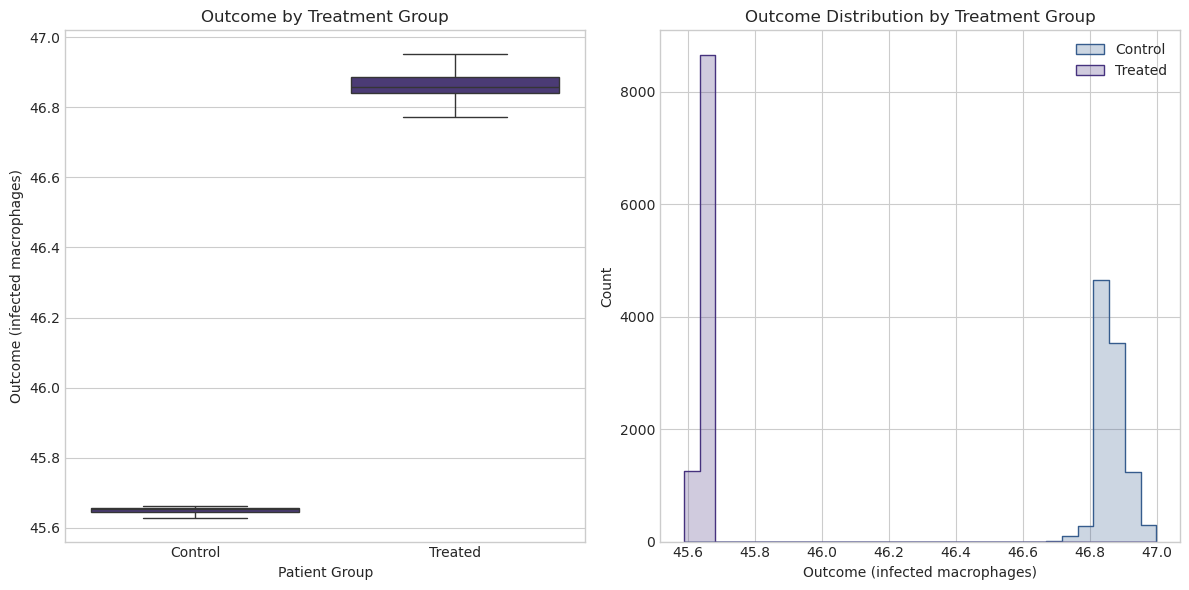

In [56]:
# Outcome distribution by treatment group
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='treatment', y='outcome', data=df, showfliers=False)
plt.xticks([0, 1], ['Control', 'Treated'])
plt.title('Outcome by Treatment Group')
plt.xlabel('Patient Group')
plt.ylabel('Outcome (infected macrophages)')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='outcome', hue='treatment', element='step', common_norm=False, bins=30)
plt.title('Outcome Distribution by Treatment Group')
plt.xlabel('Outcome (infected macrophages)')
plt.legend(['Control', 'Treated'])

plt.tight_layout()
plt.show()

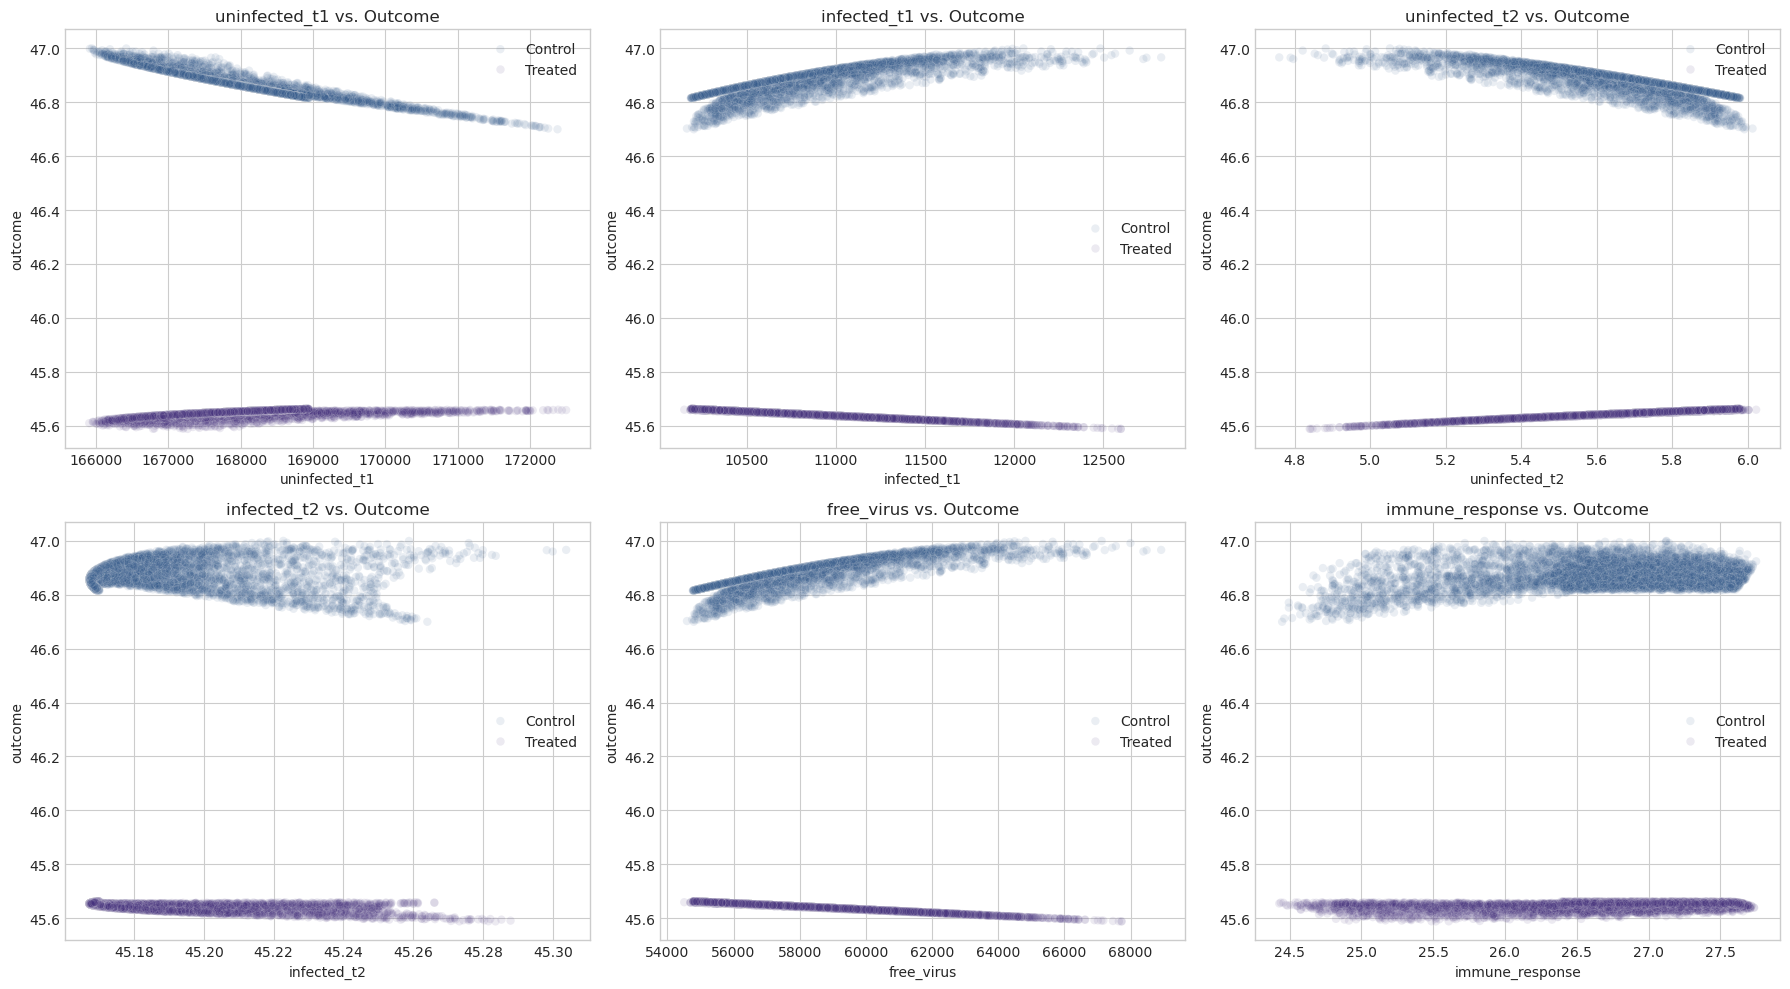

In [57]:
# Relationship between key covariates and outcome
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

covariates = ['uninfected_t1', 'infected_t1', 'uninfected_t2',
              'infected_t2', 'free_virus', 'immune_response']

for i, covariate in enumerate(covariates):
    sns.scatterplot(x=covariate, y='outcome', hue='treatment', data=df, ax=axes[i], alpha=0.1)
    axes[i].set_title(f'{covariate} vs. Outcome')
    axes[i].legend(['Control', 'Treated'])

plt.tight_layout()
plt.show()

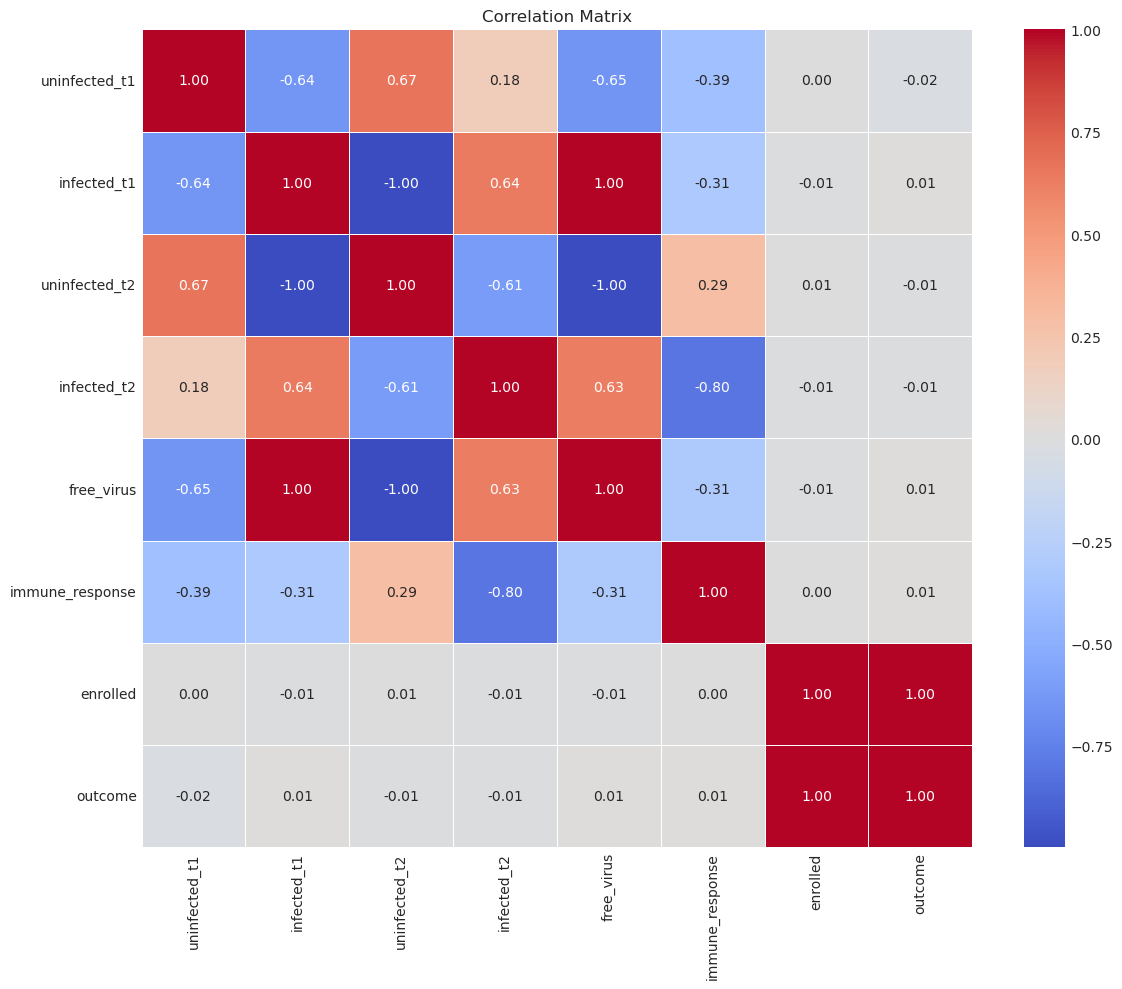

In [58]:
# Correlation matrix of covariates
correlation_vars = covariates + ['enrolled', 'outcome']
corr_matrix = df[correlation_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. Estimate Treatment Effects

In [64]:
# Define a function to estimate the treatment effect using multiple methods
def estimate_treatment_effects(df, silent=True):

    true_ate = df[df['treatment'] == 1]['true_effect'].mean()


    # Method 1: calculate the ATE directly from group means
    treated_mean = df[df['treatment'] == 1]['outcome'].mean()
    control_mean = df[df['treatment'] == 0]['outcome'].mean()
    naive_ate = treated_mean - control_mean


    # Method 2: Linear regression without covariates
    linear_model = sm.OLS(df['outcome'], sm.add_constant(df['treatment'])).fit()
    linear_ate = linear_model.params[1]

    # Method 3: Linear regression with covariates (adjustment)
    formula = 'outcome ~ treatment + ' + ' + '.join(covariates)
    linear_model_with_covariates = smf.ols(formula, data=df).fit()
    linear_with_covariates_ate = linear_model_with_covariates.params['treatment']

    # Define the causal model
    # The graph structure assumes treatment given based on study enrollment
    # and that covariates affect the outcome
    graph = '''
        digraph {
            treatment -> outcome;
            enrolled -> treatment;
            uninfected_t1 -> outcome;
            infected_t1 -> outcome;
            uninfected_t2 -> outcome;
            infected_t2 -> outcome;
            free_virus -> outcome;
            immune_response -> outcome;
        }
    '''

    causal_model = CausalModel(
        data=df,
        treatment='treatment',
        outcome='outcome',
        graph=graph,
        instruments=['enrolled']
    )

    # Identify causal effect (backdoor and IV methods)
    identified_estimand_backdoor = causal_model.identify_effect(proceed_when_unidentifiable=True)

    # Estimate causal effect using backdoor adjustment
    estimate_backdoor = causal_model.estimate_effect(
        identified_estimand_backdoor,
        method_name="backdoor.linear_regression",
        target_units="ate"
    )


    # Compare all the estimation methods
    methods = [
        "Naive Difference in Means",
        "Linear Regression",
        "Linear Regression with covariates",
        "DoWhy Backdoor Adjustment",
    ]

    estimates = [
        naive_ate,
        linear_model.params['treatment'],
        linear_model_with_covariates.params['treatment'],
        estimate_backdoor.value,
    ]

    results_df = pd.DataFrame({
        'Method': methods,
        'Estimated Effect': estimates,
        'Bias': [est - true_ate for est in estimates]
    })

    if not silent:
        print(f"True ATE: {true_ate:.4f}")
        print(f"Naive ATE (direct calculation): {naive_ate:.4f}")
        print(f"Linear Regression: {linear_ate:.4f}")
        print(linear_model.summary().tables[1])
        print(f"Linear Regression with covariates: {linear_with_covariates_ate:.4f}")
        print(linear_model_with_covariates.summary().tables[1])
        print(f"Backdoor estimate (linear regression with covariates): {estimate_backdoor.value:.4f}")

    return results_df


In [65]:
# Picking one experiment to demonstrate the methods
df_test = df[df['experiment_number'] == 0]

In [66]:
test_results = estimate_treatment_effects(df_test, silent=False)

True ATE: 1.2159
Naive ATE (direct calculation): 1.2172
Linear Regression: 1.2172
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6473      0.003   1.45e+04      0.000      45.641      45.654
treatment      1.2172      0.005    269.207      0.000       1.208       1.226
Linear Regression with covariates: 1.2218
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         392.2715   1014.767      0.387      0.700   -1609.251    2393.794
treatment           1.2218      0.004    307.799      0.000       1.214       1.230
uninfected_t1       0.0004      0.001      0.265      0.791      -0.002       0.003
infected_t1        -0.0474      0.199     -0.238      0.812      -0.440       0.345
uninfected_t2      -1.0832      3.907     -0.277      0.

## 5. Compare Estimated vs True Treatment Effects

We run the analysis separately for each experiment and plot the biases of different methods

In [67]:
experiment_results = []
for i in range(max(df['experiment_number'])):
    df_test = df[df['experiment_number'] == i]
    test_results = estimate_treatment_effects(df_test)
    experiment_results.append(test_results)

# Create a DataFrame to store the results
df_results = pd.concat(experiment_results, ignore_index=True)

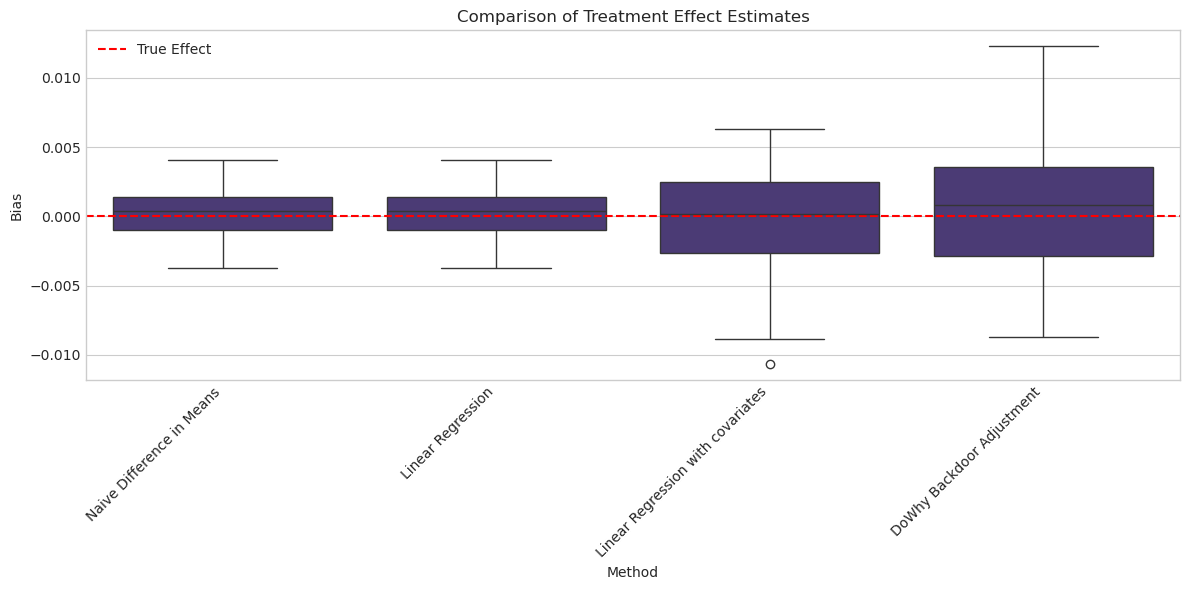

In [68]:
# Visualize the estimated vs true effects using scatter plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Method', y='Bias', data=df_results)
plt.axhline(y=0, color='r', linestyle='--', label='True Effect')
plt.legend()
plt.title('Comparison of Treatment Effect Estimates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Conclusions

In this analysis, we explored the HIV treatment dataset with full compliance and estimated the causal effect of treatment using various methods:

1. **Naive approach**: Simple difference in means between treatment and control groups
2. **Simple regression**: Linear regression with treatment as the only predictor is equivalent to difference in means
3. **Covariate adjustment**: Linear regression controlling for observed covariates
4. **Backdoor adjustment**: DoWhy's implementation of the backdoor criterion for causal estimation using linear regression with covariates as the model

Key findings:
- With full compliance, the naive/simple regression is the best approach. The experiment design itself controls for other factors and trying to adjust for these factors with other methods actually increases the variance in the results significantly, though the estimated are still unbiased
- Covariate adjustment makes the estimates less accurate, by introducing more variance to the estimate caused by variation in the covariates. If the compliance in the experiment would not be perfect this might be desirable tradeoff as it can fix things when they are broken, but in this case there is nothing to fix so we just lose accuracy.
- One would think that adding accurate causal assumptions to the covariate model should make things better, but this is not case. Even if we are adding more information the method how this information is incorporated adds more complexity and noise and in the end we have even worse estimates than with pure linear model with covariates

In the case of flawlessly run experiment, using more complex inference methods won't give us a better estimates on average. The experimental setup takes care of controlling for other causal factors and try to deal with these with other methods at the same time leads to just more variance in the estimates